In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [ ]:
data = pd.read_csv("/content/train_hsbc_df.csv")
data.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C583110837','3','M','28007','M480139044','28007','es_health',44.26,1
1,0,'C1332295774','3','M','28007','M480139044','28007','es_health',324.50,1
2,0,'C1160421902','3','M','28007','M857378720','28007','es_hotelservices',176.32,1
3,0,'C966214713','3','M','28007','M857378720','28007','es_hotelservices',337.41,1
4,0,'C1450140987','4','F','28007','M1198415165','28007','es_wellnessandbeauty',220.11,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513643 entries, 0 to 513642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         513643 non-null  int64  
 1   customer     513643 non-null  object 
 2   age          513643 non-null  object 
 3   gender       513643 non-null  object 
 4   zipcodeOri   513643 non-null  object 
 5   merchant     513643 non-null  object 
 6   zipMerchant  513643 non-null  object 
 7   category     513643 non-null  object 
 8   amount       513643 non-null  float64
 9   fraud        513643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 39.2+ MB


In [ ]:
print(data.describe())

                step         amount          fraud
count  513643.000000  513643.000000  513643.000000
mean       94.992629      37.915481       0.012071
std        51.063474     111.557455       0.109201
min         0.000000       0.000000       0.000000
25%        52.000000      13.740000       0.000000
50%        97.000000      26.920000       0.000000
75%       139.000000      42.550000       0.000000
max       179.000000    7665.560000       1.000000


In [ ]:
print(data.fraud.value_counts())

fraud
0    507443
1      6200
Name: count, dtype: int64


In [ ]:
pd.concat([df_fraud.groupby('category')['amount'].mean(),df_non_fraud.groupby('category')['amount'].mean(),\
           data.groupby('category')['fraud'].mean()*100],keys=["Fraudulent","Non-Fraudulent","Percent(%)"],axis=1,\
          sort=False).sort_values(by=['Non-Fraudulent'])

,Fraudulent,Non-Fraudulent,Percent(%)
category,,,
'es_transportation',NaN,26.961980,0.000000
'es_food',NaN,37.199899,0.000000
'es_hyper',169.784733,40.091598,4.596179
'es_barsandrestaurants',160.786471,41.266476,1.838500
'es_contents',NaN,44.691230,0.000000
'es_wellnessandbeauty',229.719435,57.385406,4.745477
'es_fashion',251.841887,62.638892,1.904078
'es_leisure',299.447956,73.844286,95.138889
'es_otherservices',320.552277,74.403217,25.187032


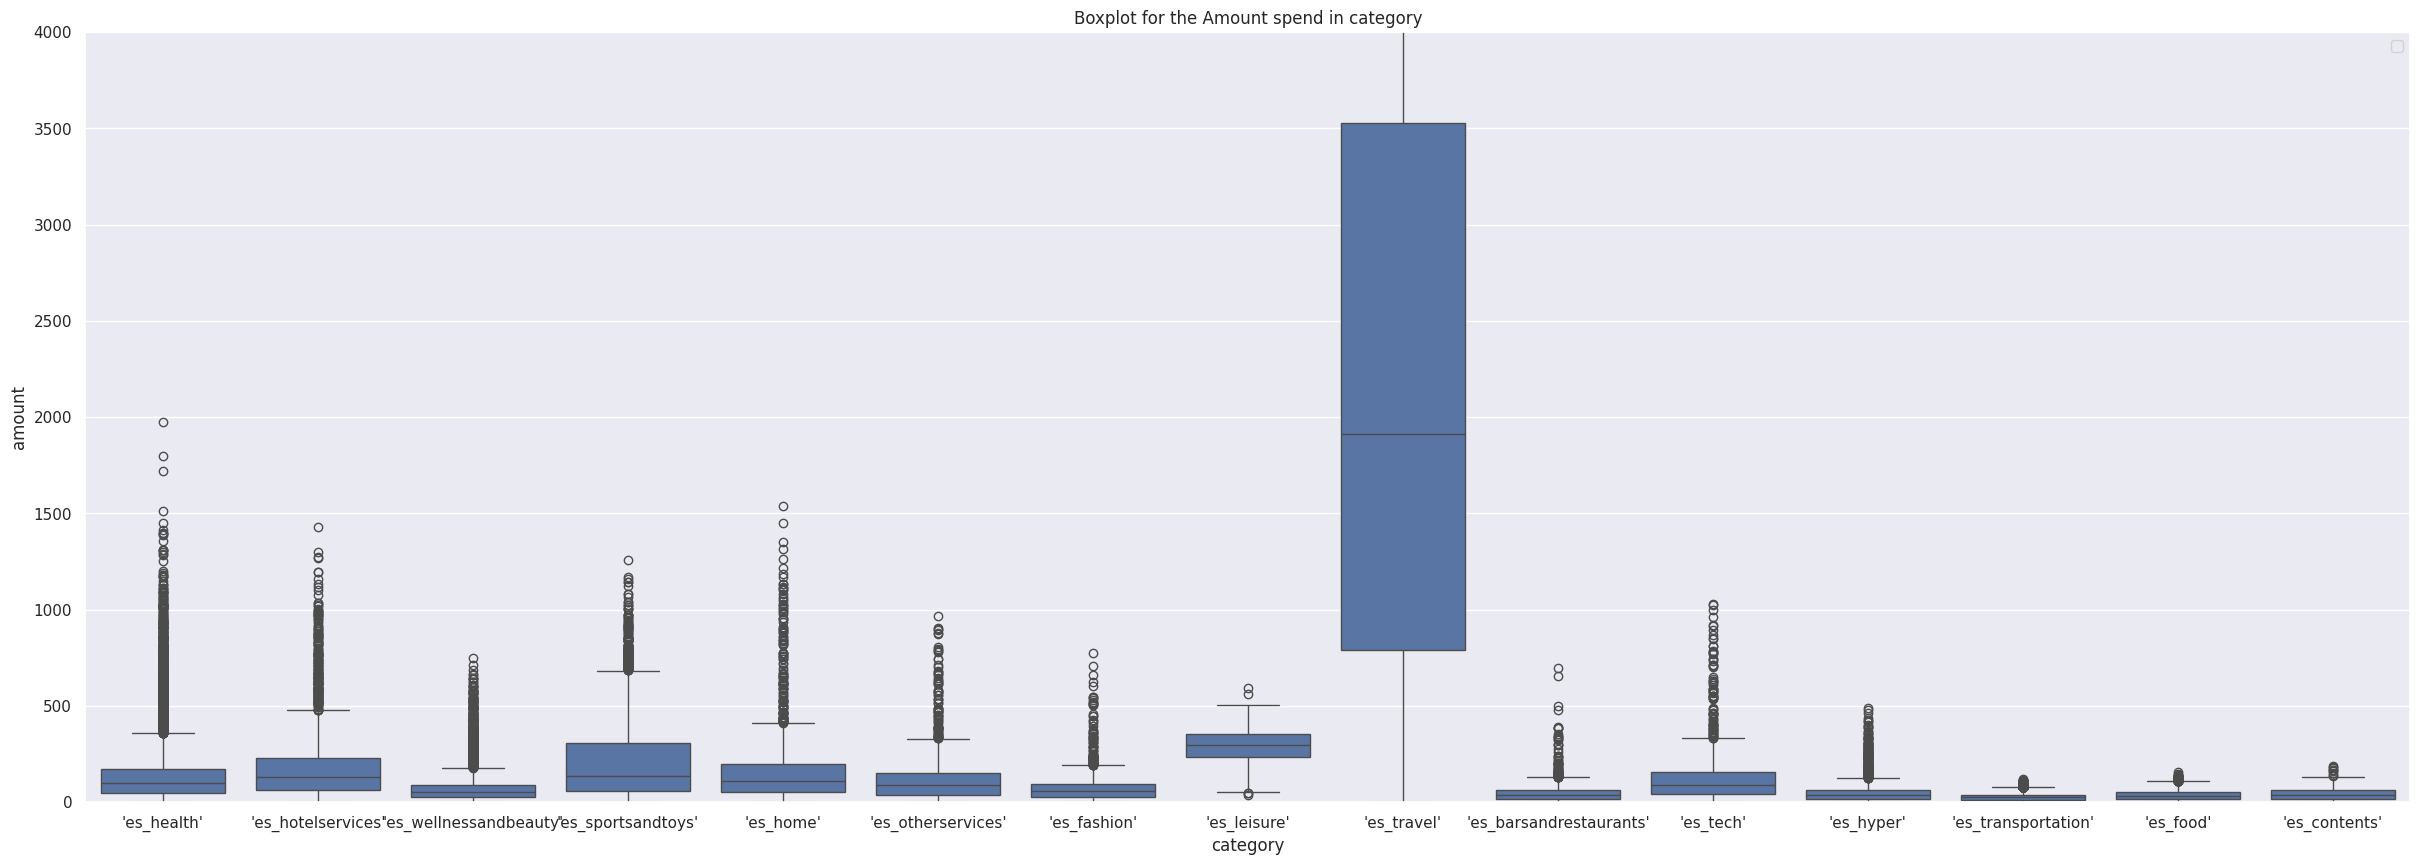

In [ ]:
plt.figure(figsize=(30,10))
sns.boxplot(x=data.category,y=data.amount)
plt.title("Boxplot for the Amount spend in category")
plt.ylim(0,4000)
plt.legend()
plt.show()

In [ ]:
print((data.groupby('age')['fraud'].mean()*100).reset_index().rename(columns={'age':'Age','fraud' : 'Fraud Percent'}).sort_values(by='Fraud Percent'))

   Age  Fraud Percent
7  'U'       0.594648
6  '6'       1.015010
5  '5'       1.091158
1  '1'       1.193703
3  '3'       1.196969
2  '2'       1.231691
4  '4'       1.289418
0  '0'       1.952381


In [ ]:
print((data.groupby('gender')['fraud'].mean()*100).reset_index().rename(columns={'gender':'gender','fraud' : 'Fraud Percent'}).sort_values(by='Fraud Percent'))

  gender  Fraud Percent
3    'U'       0.000000
0    'E'       0.594648
2    'M'       0.904749
1    'F'       1.461461


Unique values in 'age' column before cleaning:
["'3'" "'4'" "'2'" "'5'" "'1'" "'6'" "'0'" "'U'"]

Rows with NaN in 'age' after conversion:
        step       customer  age gender zipcodeOri       merchant zipMerchant  \
3223      94  'C1208164294'  NaN    'E'    '28007'   'M480139044'     '28007'   
3445     100  'C2075935351'  NaN    'E'    '28007'  'M2122776122'     '28007'   
3636     106  'C1871125244'  NaN    'E'    '28007'   'M855959430'     '28007'   
3660     106  'C1215440829'  NaN    'E'    '28007'    'M78078399'     '28007'   
4699     136  'C1208164294'  NaN    'E'    '28007'  'M1294758098'     '28007'   
...      ...            ...  ...    ...        ...            ...         ...   
511073   179   'C808326652'  NaN    'E'    '28007'  'M1823072687'     '28007'   
511706   179  'C1215440829'  NaN    'E'    '28007'  'M1823072687'     '28007'   
511892   179  'C2075935351'  NaN    'E'    '28007'  'M1823072687'     '28007'   
513191   179  'C1374607221'  NaN    'E'    '28007' 

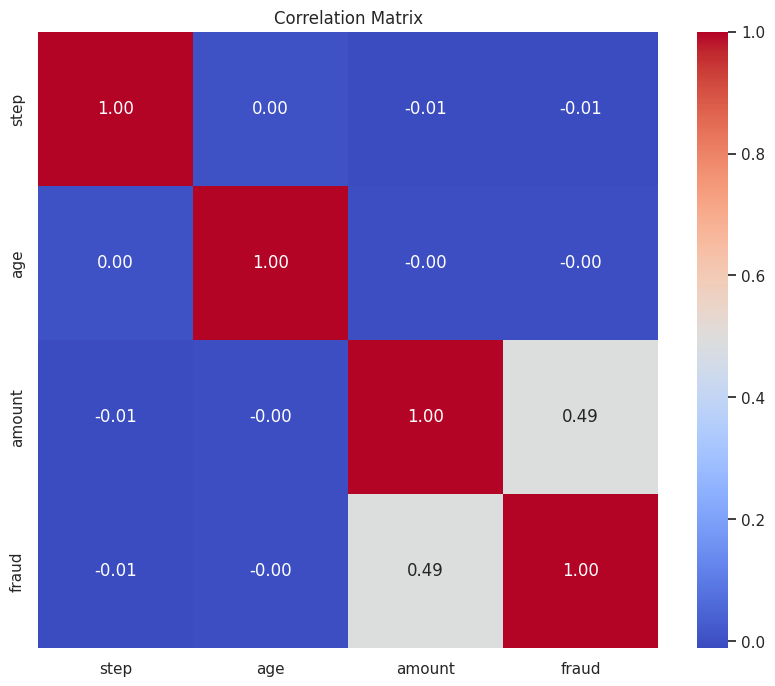

In [ ]:

df = pd.DataFrame(data)

print("Unique values in 'age' column before cleaning:")
print(df['age'].unique())

df['age'] = pd.to_numeric(df['age'].str.strip("'"), errors='coerce')

print("\nRows with NaN in 'age' after conversion:")
print(df[df['age'].isna()])

df['gender'] = df['gender'].astype('category').cat.codes
df['zipcodeOri'] = df['zipcodeOri'].astype('category').cat.codes
df['merchant'] = df['merchant'].astype('category').cat.codes
df['zipMerchant'] = df['zipMerchant'].astype('category').cat.codes
df['category'] = df['category'].astype('category').cat.codes

df_numeric = df.select_dtypes(include=['float64', 'int64'])

correlation_matrix = df_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
print("Unique zipCodeOri values: ",data.zipcodeOri.nunique())
print("Unique zipMerchant values: ",data.zipMerchant.nunique())
# dropping zipcodeori and zipMerchant since they have only one unique value
data_reduced = data.drop(['zipcodeOri','zipMerchant'],axis=1)

Unique zipCodeOri values:  1
Unique zipMerchant values:  1


In [ ]:
data_reduced.columns

Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount',
       'fraud'],
      dtype='object')

In [ ]:
col_categorical = data_reduced.select_dtypes(include= ['object']).columns
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category')
# categorical values ==> numeric values
data_reduced[col_categorical] = data_reduced[col_categorical].apply(lambda x: x.cat.codes)
data_reduced.head(5)

,step,customer,age,gender,merchant,category,amount,fraud
0,0,3219,3,2,34,4,44.26,1
1,0,723,3,2,34,4,324.50,1
2,0,362,3,2,44,6,176.32,1
3,0,4040,3,2,44,6,337.41,1
4,0,969,4,1,2,14,220.11,1


In [ ]:
X = data_reduced.drop(['fraud'],axis=1)
y = data['fraud']
print(X.head(),"\n")
print(y.head())

   step  customer  age  gender  merchant  category  amount
0     0      3219    3       2        34         4   44.26
1     0       723    3       2        34         4  324.50
2     0       362    3       2        44         6  176.32
3     0      4040    3       2        44         6  337.41
4     0       969    4       1         2        14  220.11 

0    1
1    1
2    1
3    1
4    1
Name: fraud, dtype: int64


In [ ]:
y[y==1].count()

6200

In [ ]:
# from imblearn.over_sampling import SMOTE

# # Separate features and target variable
# X = data_reduced.drop(['fraud'], axis=1)
# y = data['fraud']

# # Initialize SMOTE
# smote = SMOTE(random_state=42)

# # Fit and resample the data
# X_resampled, y_resampled = smote.fit_resample(X, y)

# # Display the number of samples in each class after resampling
# print(f'Number of samples in the minority class after resampling: {sum(y_resampled == 1)}')
# print(f'Number of samples in the majority class after resampling: {sum(y_resampled == 0)}')


Number of samples in the minority class after resampling: 507443
Number of samples in the majority class after resampling: 507443


In [ ]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
y_res = pd.DataFrame(y_res)
# print(y_res[0].value_counts())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=42,shuffle=True,stratify=y_res)

In [ ]:
print("Base accuracy score we must beat is: ",
      df_non_fraud.fraud.count()/ np.add(df_non_fraud.fraud.count(),df_fraud.fraud.count()) * 100)

Base accuracy score we must beat is:  98.7929359496771


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   45.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s


Classification Report for Random Forest Classifier: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    152233
           1       0.97      0.99      0.98    152233

    accuracy                           0.98    304466
   macro avg       0.98      0.98      0.98    304466
weighted avg       0.98      0.98      0.98    304466

Confusion Matrix of Random Forest Classifier: 
 [[146936   5297]
 [   911 151322]]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s


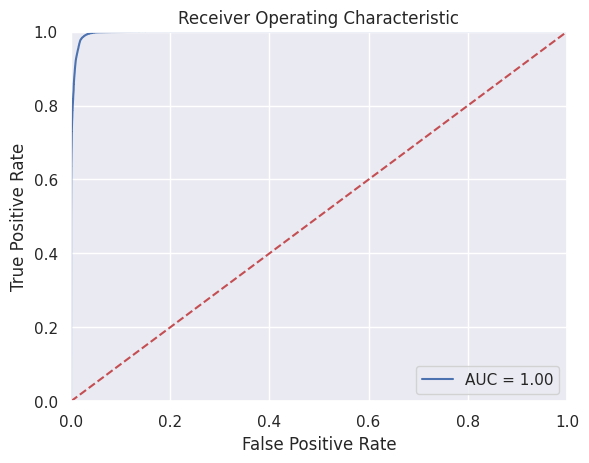

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100,max_depth=8,random_state=42,
                                verbose=1,class_weight="balanced")

rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)

print("Classification Report for Random Forest Classifier: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Random Forest Classifier: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, rf_clf.predict_proba(X_test)[:,1])

Classification Report for XGBoost: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    152233
           1       0.99      1.00      0.99    152233

    accuracy                           0.99    304466
   macro avg       0.99      0.99      0.99    304466
weighted avg       0.99      0.99      0.99    304466

Confusion Matrix of XGBoost: 
 [[150483   1750]
 [   709 151524]]


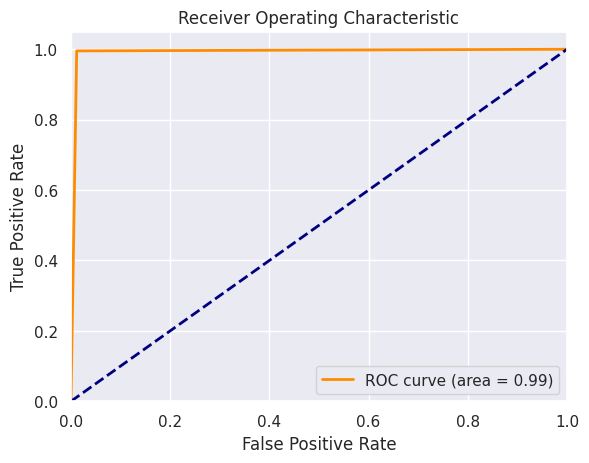

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# Initialize the XGBoost classifier with essential parameters
XGBoost_CLF = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.05,
    n_estimators=400,
    objective="binary:hinge",  # For binary classification hinge loss
    booster='gbtree',
    random_state=42,
    verbosity=1  # Use integer for verbosity
)

# Fit the model
XGBoost_CLF.fit(X_train, y_train)

# Predict on the test set
y_pred = XGBoost_CLF.predict(X_test)

# Print classification report and confusion matrix
print("Classification Report for XGBoost: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of XGBoost: \n", confusion_matrix(y_test, y_pred))

# Plot ROC AUC
plot_roc_auc(y_test, XGBoost_CLF.predict_proba(X_test)[:,1])


In [ ]:
data = pd.read_csv("/content/test.csv")
data.head(5)

data_reduced = data.drop(['zipcodeOri','zipMerchant'],axis=1)
data_reduced.columns

col_categorical = data_reduced.select_dtypes(include= ['object']).columns
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category')
# categorical values ==> numeric values
data_reduced[col_categorical] = data_reduced[col_categorical].apply(lambda x: x.cat.codes)
data_reduced.head(5)

X = data_reduced.drop(['fraud'],axis=1)
y = data['fraud']
print(X.head(),"\n")
print(y.head())


sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
y_res = pd.DataFrame(y_res)

X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=42,shuffle=True,stratify=y_res)

rf_clf = RandomForestClassifier(n_estimators=100,max_depth=8,random_state=42,
                                verbose=1,class_weight="balanced")

rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)

print("Classification Report for Random Forest Classifier: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Random Forest Classifier: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, rf_clf.predict_proba(X_test)[:,1])


import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# Initialize the XGBoost classifier with essential parameters
XGBoost_CLF = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.05,
    n_estimators=400,
    objective="binary:hinge",  # For binary classification hinge loss
    booster='gbtree',
    random_state=42,
    verbosity=1  # Use integer for verbosity
)

# Fit the model
XGBoost_CLF.fit(X_train, y_train)

# Predict on the test set
y_pred = XGBoost_CLF.predict(X_test)

# Print classification report and confusion matrix
print("Classification Report for XGBoost: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of XGBoost: \n", confusion_matrix(y_test, y_pred))

# Plot ROC AUC
plot_roc_auc(y_test, XGBoost_CLF.predict_proba(X_test)[:,1])



ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:customer: object, age: object, gender: object, zipcodeOri: object, merchant: object, zipMerchant: object, category: object

In [138]:
import joblib
import pandas as pd
from sklearn.metrics import precision_score, accuracy_score, recall_score, roc_auc_score, f1_score

# Load the saved model
model = joblib.load('xgboost_model.pkl')

# Load and preprocess the test data
data = pd.read_csv("/content/test_hsbc_df.csv")
data_reduced = data.drop(['zipcodeOri', 'zipMerchant'], axis=1)

# Convert categorical values to numeric
col_categorical = data_reduced.select_dtypes(include=['object']).columns
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category')
data_reduced[col_categorical] = data_reduced[col_categorical].apply(lambda x: x.cat.codes)

# Separate features and target
X_test = data_reduced.drop(['fraud'], axis=1)
y_test = data['fraud']

# Make predictions
y_pred = model.predict(X_test)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])  # Assuming binary classification
f1 = f1_score(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')
print(f'F1 Score: {f1:.2f}')


Accuracy: 0.83
Precision: 0.82
Recall: 0.96
ROC AUC: 0.84
F1 Score: 0.83
